$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

Bradley Pospeck

## Overview

For this assignment, an implementation of deep Q learning will be used to learn how to push a marble. The environment will simply be a 1 dimensional line with boundaries from 0-10. There are 3 actions that can be taken:
    1. Push the marble left
    2. Push the marble right
    3. Leave the marble alone
    
The object of the learning is to push the marble into a designated goal. That goal is designated randomly with each sample and can be any of the integer positions from 0-9. 

Most of the assignment uses existing code that had a fixed goal of 5. After making the goal random, different parameters will be adjusted in isolated tests in order to get an idea of what changes are most effective.

## Functions and Imports

In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

In [3]:
validActions = np.array([ -1, 0, 1]) #[Push marble left, leave marble alone, Push marble right]

def initialState():
    '''[marble position,marble velocity,goal]'''
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()), int(10*np.random.random_sample())])

def nextState(s,a):
    '''Uses Euler integration to determine the marble's next state from the current position and velocity'''
    if np.size(s) <3:
        print("s less than 3: {}".format(s))
    
    s = copy.copy(s)   # s[0] is position, s[1] is velocity, s[2] is goal. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
                                           # Goal doesn't need updating, won't change
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0,s[2]])
    elif s[0] > 10:
        s = np.array([10,0,s[2]])
    return s

#Want to maximize the rewards
def reinforcement(s):  # s is new state
    '''Returns a 0 reinforcement if marble is within 1 unit of the goal. Otherwise returns a -.1.'''
    goal = s[2]
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    '''Determines next action to take. As epsilon decays, it will pick what it thinks is the best action more often'''
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [4]:
def makeSamples(qnet, nStepsPerStart, goal=0, needGoal=False):
    '''Sets up a sample marble in the environment and initializes state.'''
    samples = []
    state = initialState()
    if needGoal: #For multiple plots after training is finished: Ensures new samples graphed have same goal
        state[2] = goal
    #print(state[2])
    act = policy(qnet, state, epsilon)
    #print(act)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        #print("state: {}, action: {}, newState: {}".format(state,act,newState))
        #print(newState)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

Now we can play.  Define constants we need.

In [5]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace, goal):
    '''Handles all of the plots and contours except for the trajectories'''
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [goal,goal],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    qs = qnet.use(np.array([[s,0,goal,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([goal-1,goal+1],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

def testIt(qnet,nTrials,nStepsPerTrial,goal):
    '''Plots the trajectories'''
    xs = np.linspace(0,10,nTrials)
    plt.subplot(4,3,12)
    for x in xs:
        s = [x,0,goal] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goal,goal],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

## Experiments

I ran a set of 5 different tests, playing with individual parameters in each, several times. Based on the results I received from running multiple times, I determined what parameters seemed to have positive and negative impacts on the algorithm. I kept track of relative results of each set compared to the base and essentially averaged those results to determine their usefulness. 

### First Test

I doubt 300 trials will be enough with a random goal, so I'll start by increasing the number of trials up to 1600 and see how it performs. I intend to keep `nTrials` at 1600 as a base going forward as I adjust other parameters.

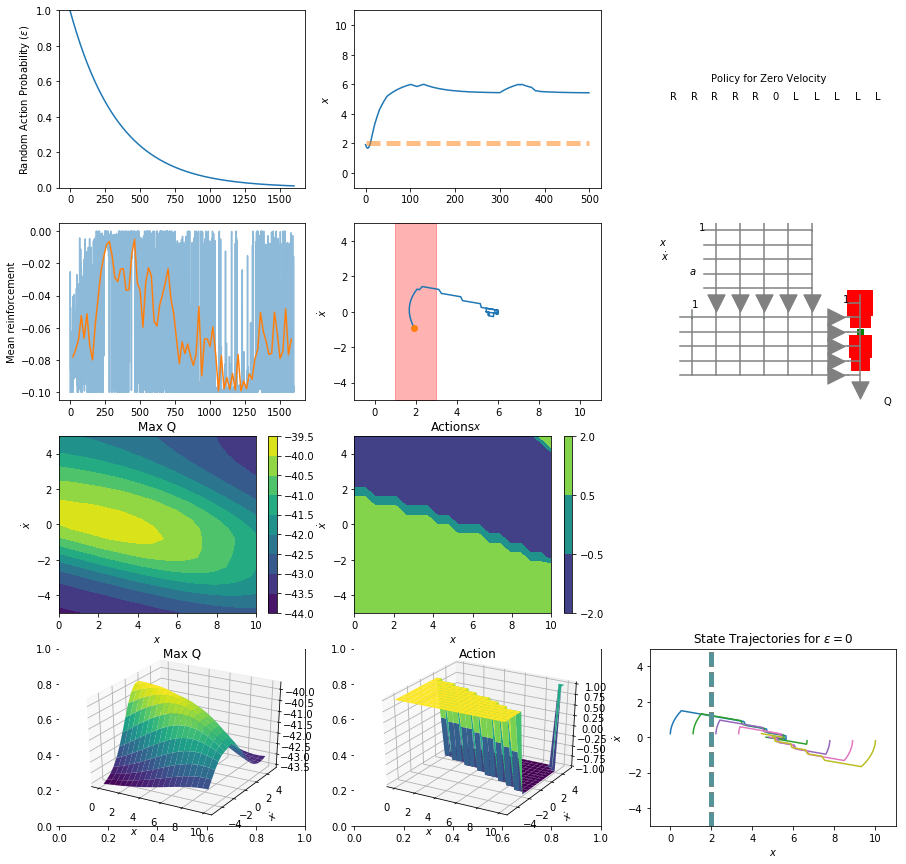

In [6]:
gamma = 0.999
nTrials = 1600
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0,10), (-1,1)))

fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
prevGoal = -1

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)
    #print("samples: {}, goal: {}".format(samples[0],samples[0][2]))
    goal = samples[0][2]
    if goal != prevGoal:
        #print(goal)
        prevGoal = goal

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        testIt(qnet,10,500,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

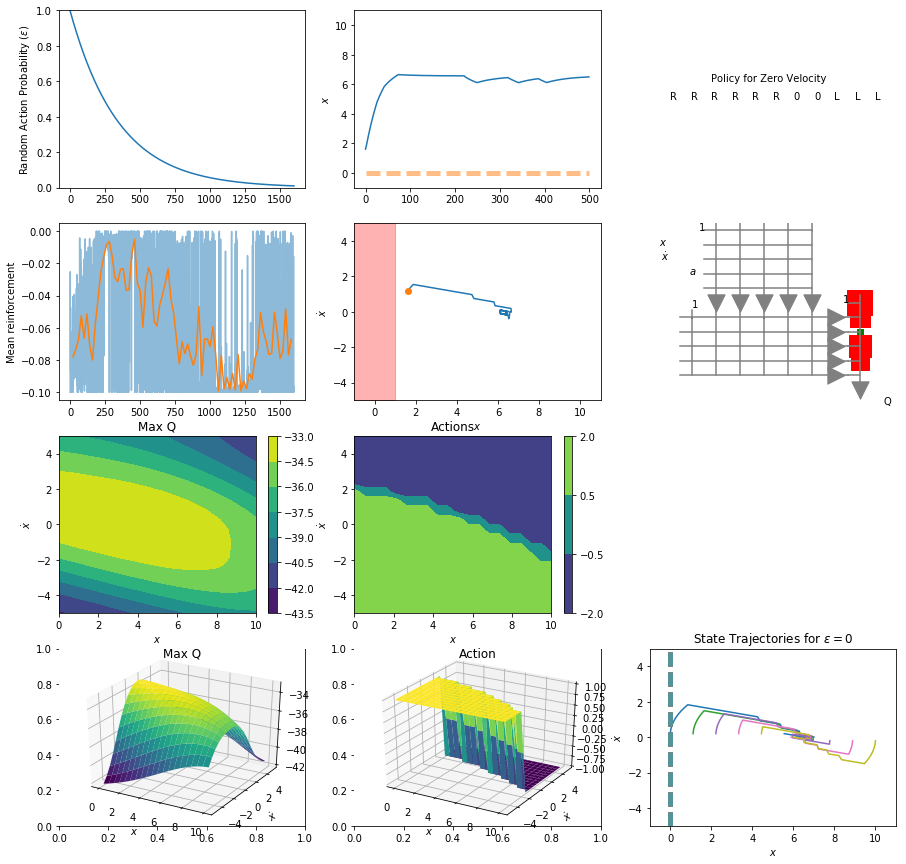

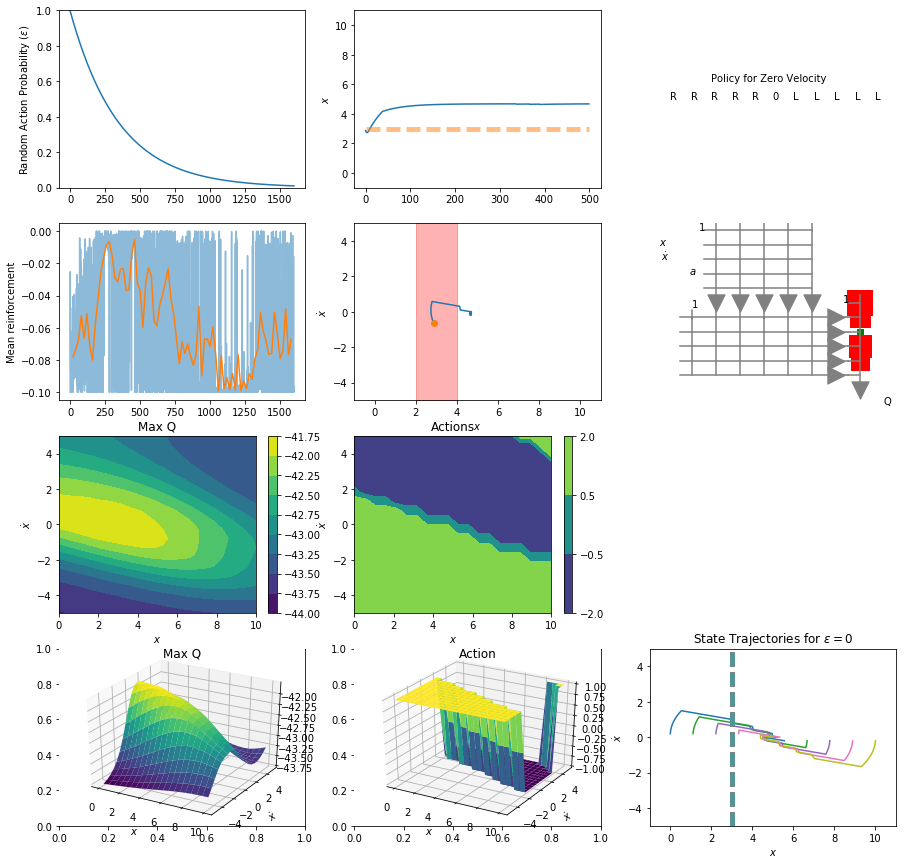

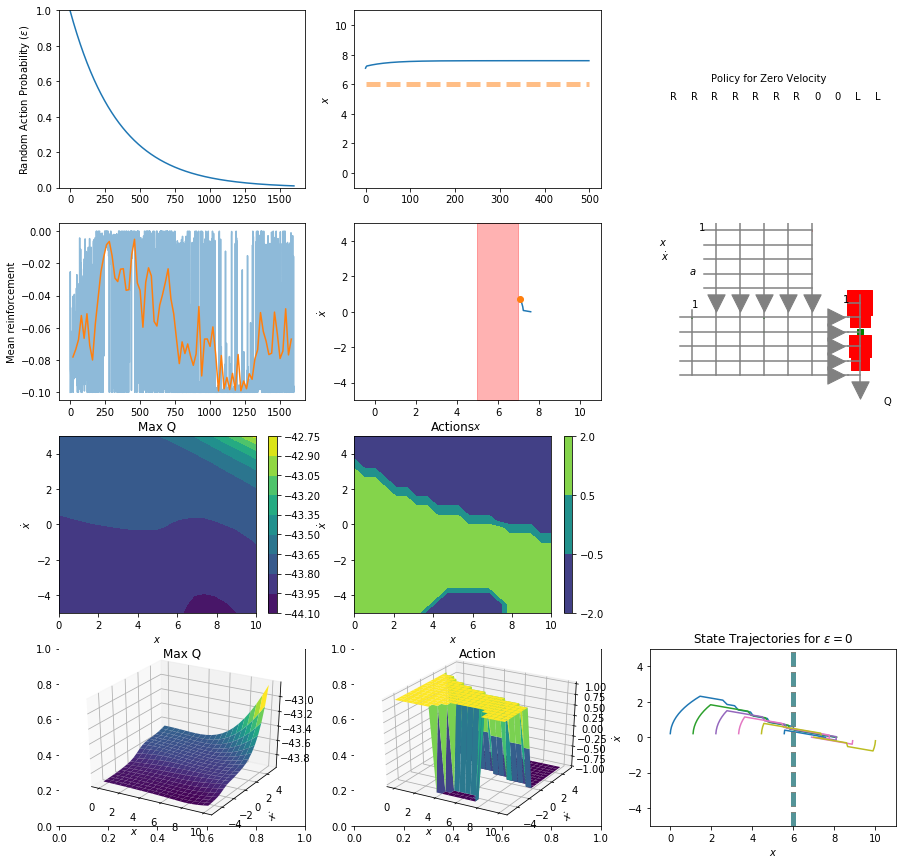

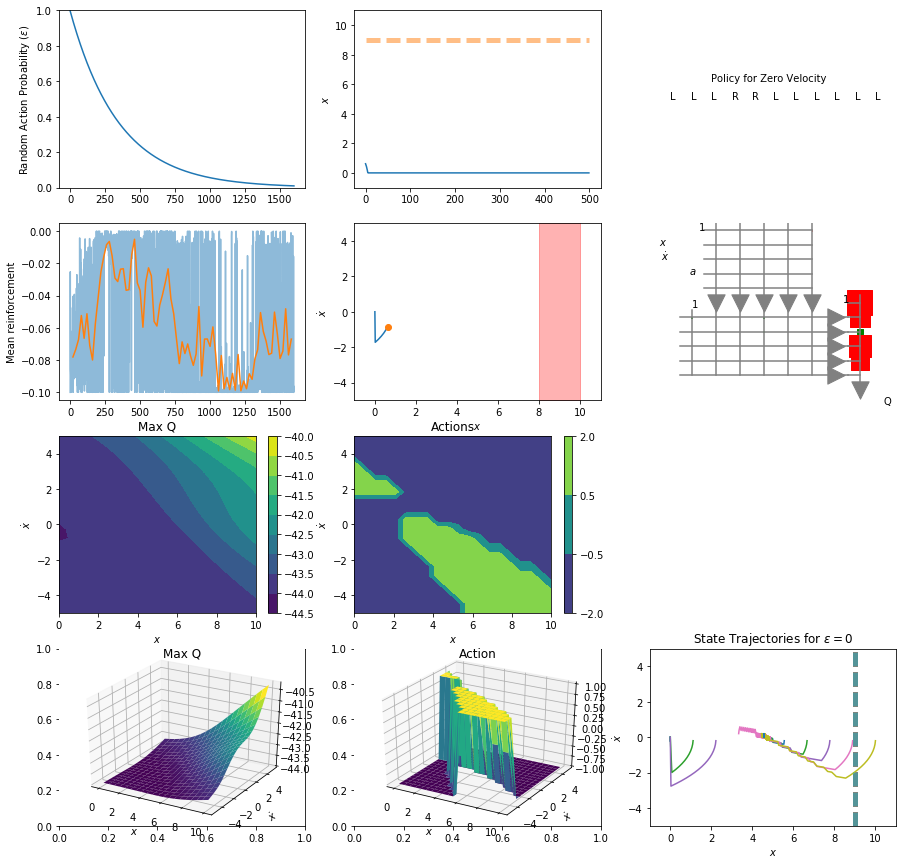

In [8]:
for goal in range(0,10,3):
    samples = makeSamples(qnet, nStepsPerTrial, goal, True)
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]    
    
    fig = plt.figure(figsize=(15,15))
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
    testIt(qnet,10,500,goal)
    display(fig);
clear_output(wait=True)

Overall, the base was decent at best. Sometimes it ran really well, other times it did horribly, and potentially anywhere in between.

### Second Test

Next I'll incrase `nSCGIterations` to 40.

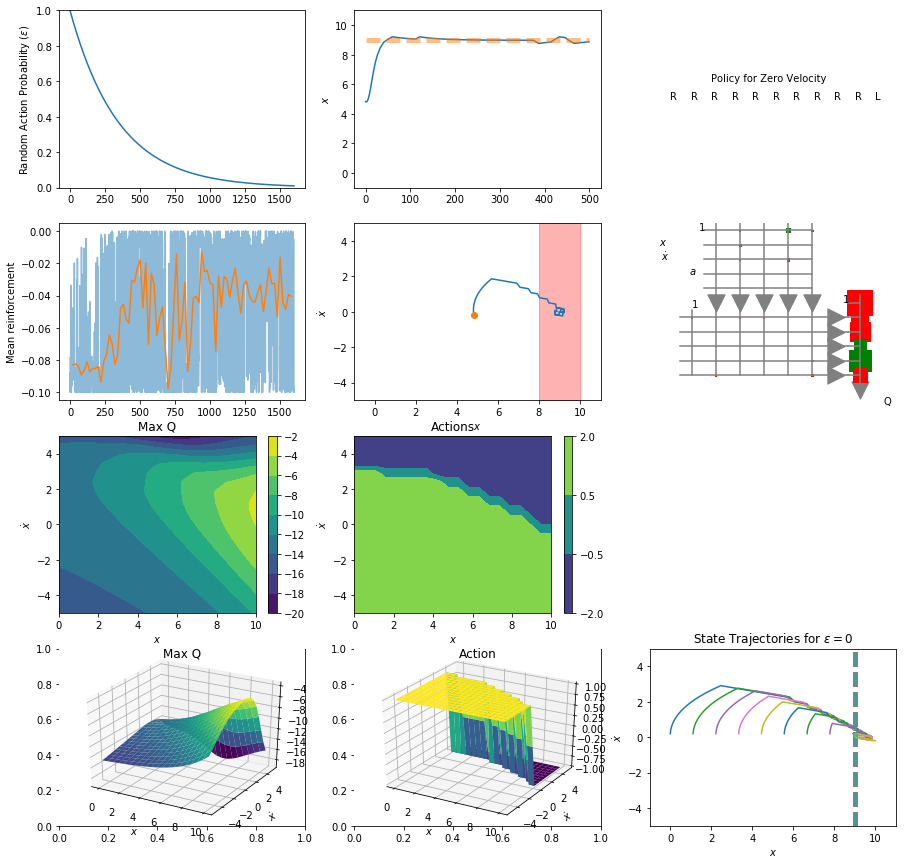

In [9]:
gamma = 0.999
nTrials = 1600
nStepsPerTrial = 500 
nSCGIterations = 40
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0,10), (-1,1)))

fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
prevGoal = -1

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)
    #print("samples: {}, goal: {}".format(samples[0],samples[0][2]))
    goal = samples[0][2]
    if goal != prevGoal:
        #print(goal)
        prevGoal = goal

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        testIt(qnet,10,500,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

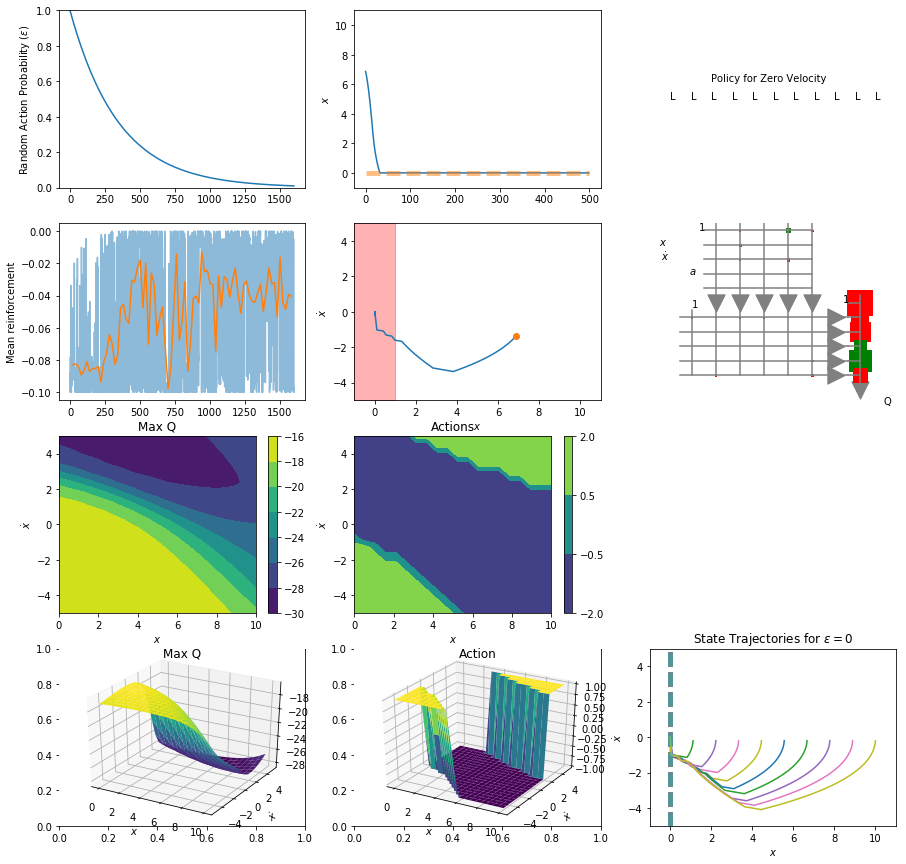

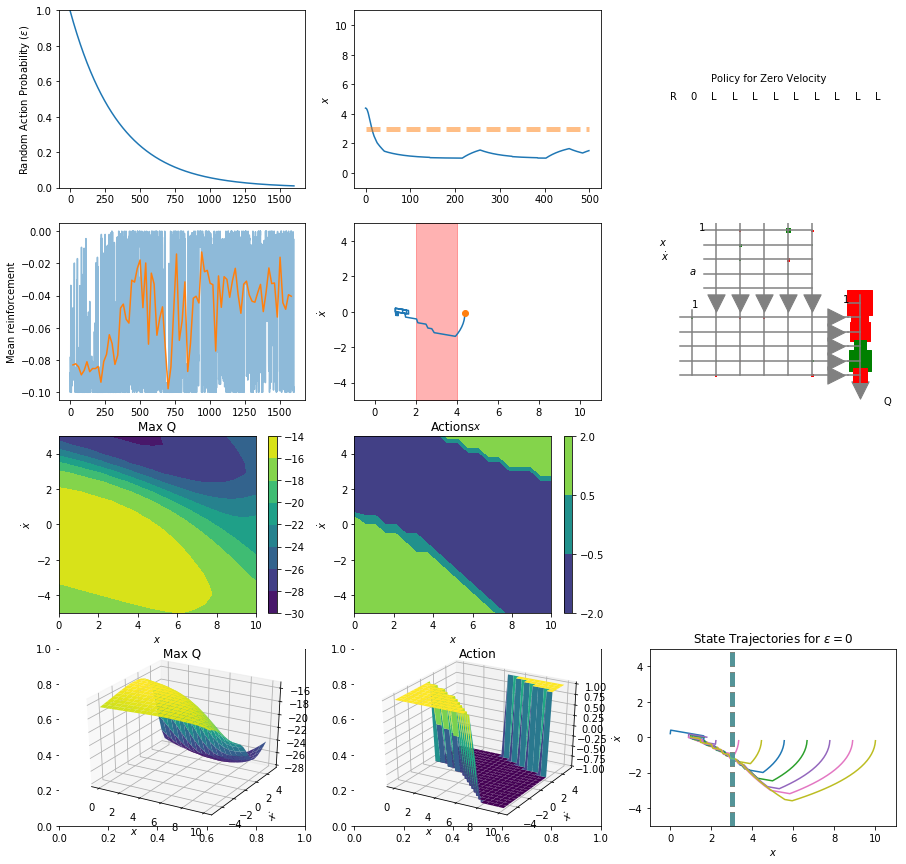

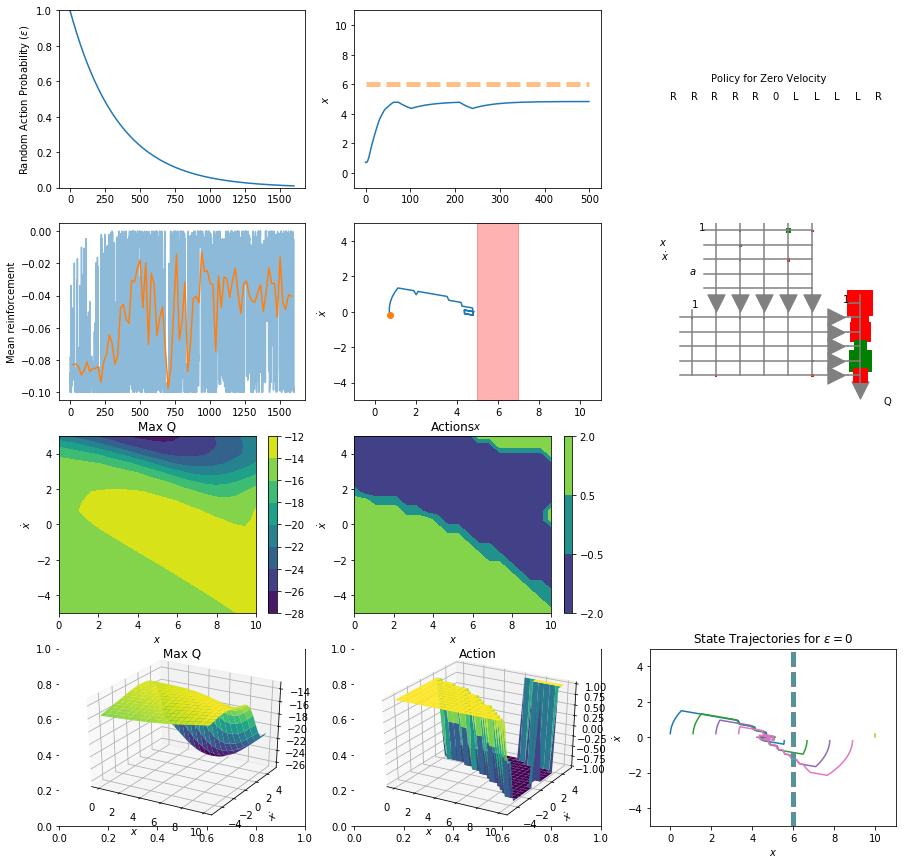

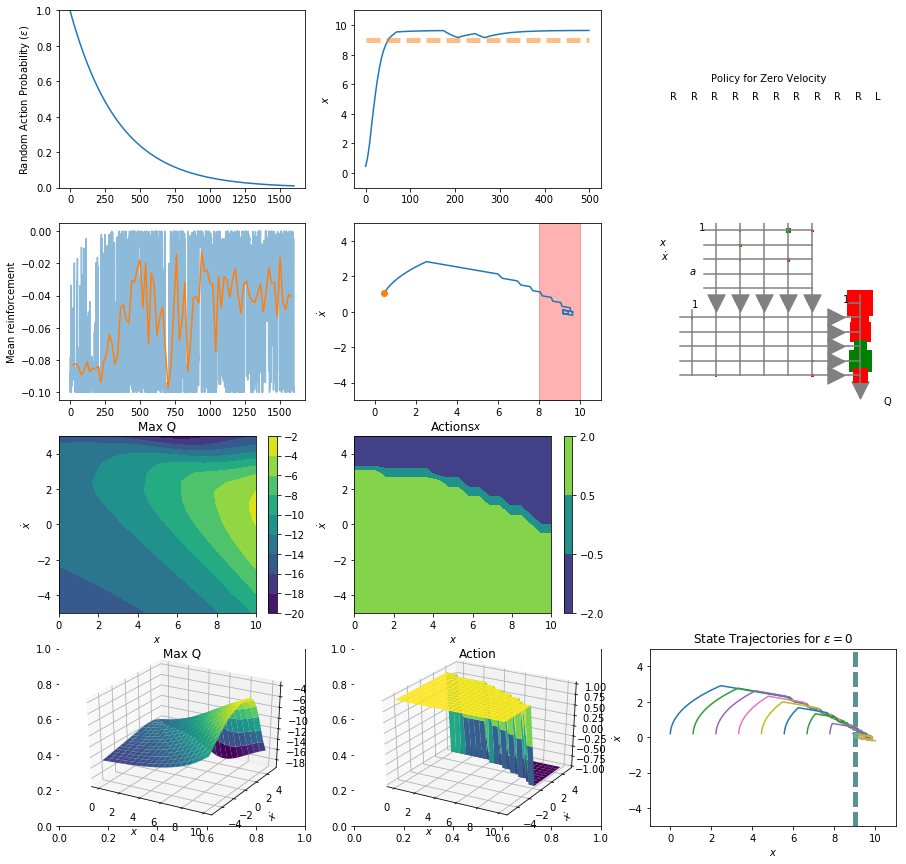

In [10]:
for goal in range(0,10,3):
    samples = makeSamples(qnet, nStepsPerTrial, goal, True)
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]    
    
    fig = plt.figure(figsize=(15,15))
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
    testIt(qnet,10,500,goal)
    display(fig);
clear_output(wait=True)

The majority of the time, increasing the iterations in the Scaled Conjugate Gradient resulted in better outputs than the base. I'll use this in my final setup.

### Third Test

Put `nSCGIterations` back to 30. increase `nStepsPerTrial` to 600.

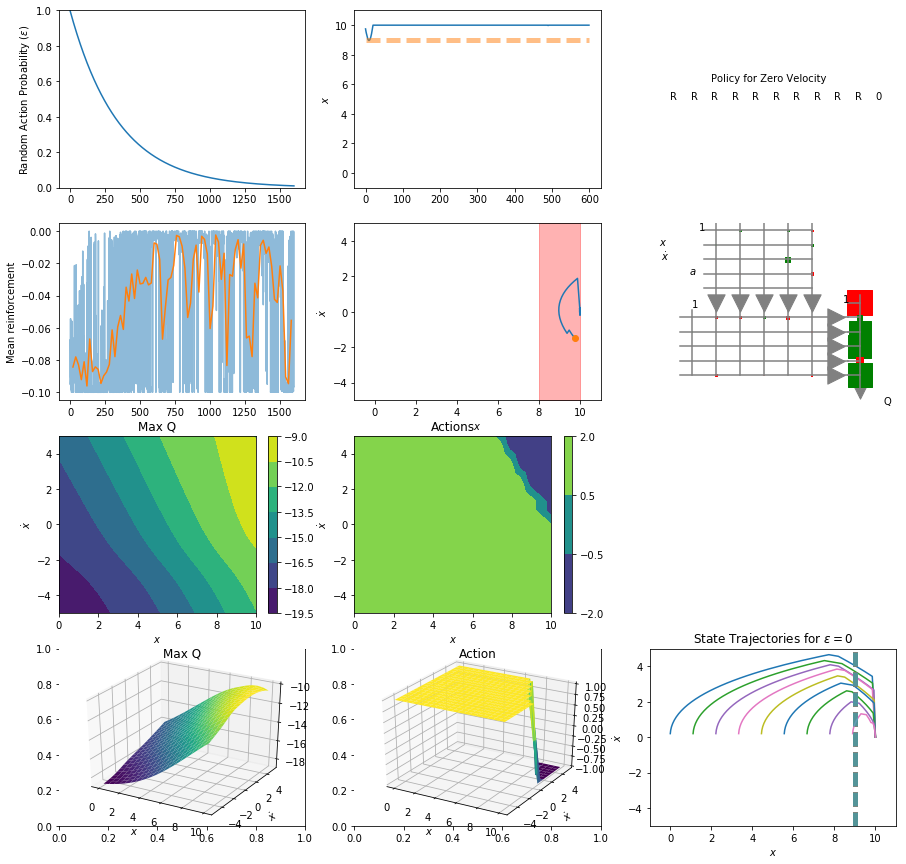

In [11]:
gamma = 0.999
nTrials = 1600
nStepsPerTrial = 600 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0,10), (-1,1)))

fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
prevGoal = -1

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)
    #print("samples: {}, goal: {}".format(samples[0],samples[0][2]))
    goal = samples[0][2]
    if goal != prevGoal:
        #print(goal)
        prevGoal = goal

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        testIt(qnet,10,500,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

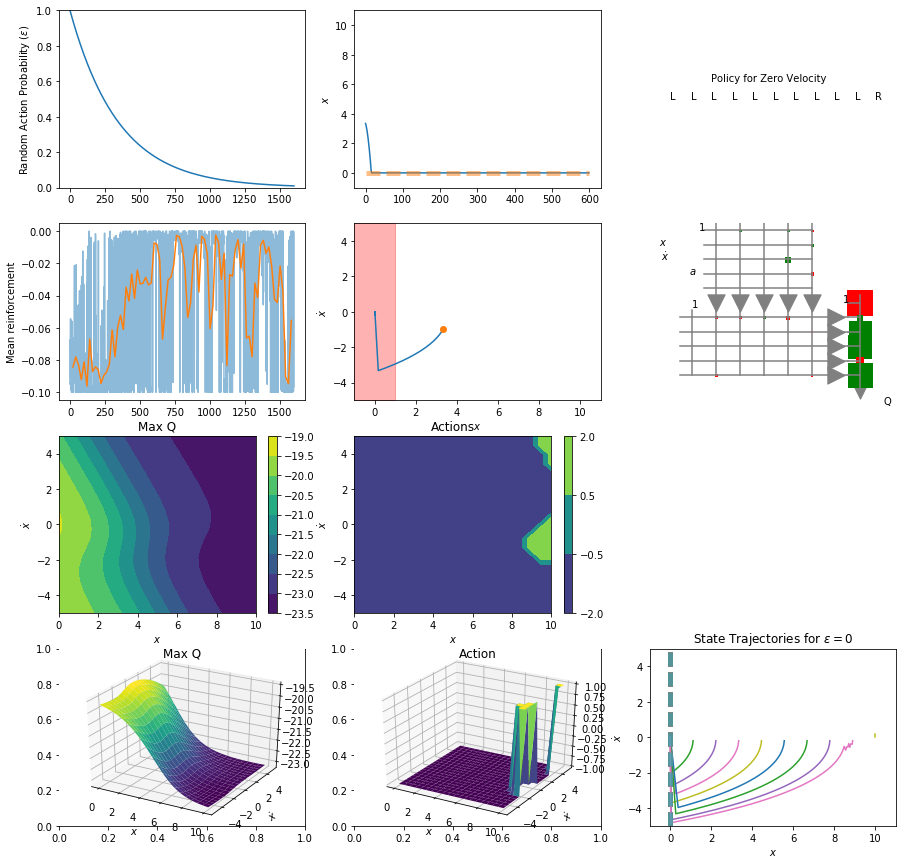

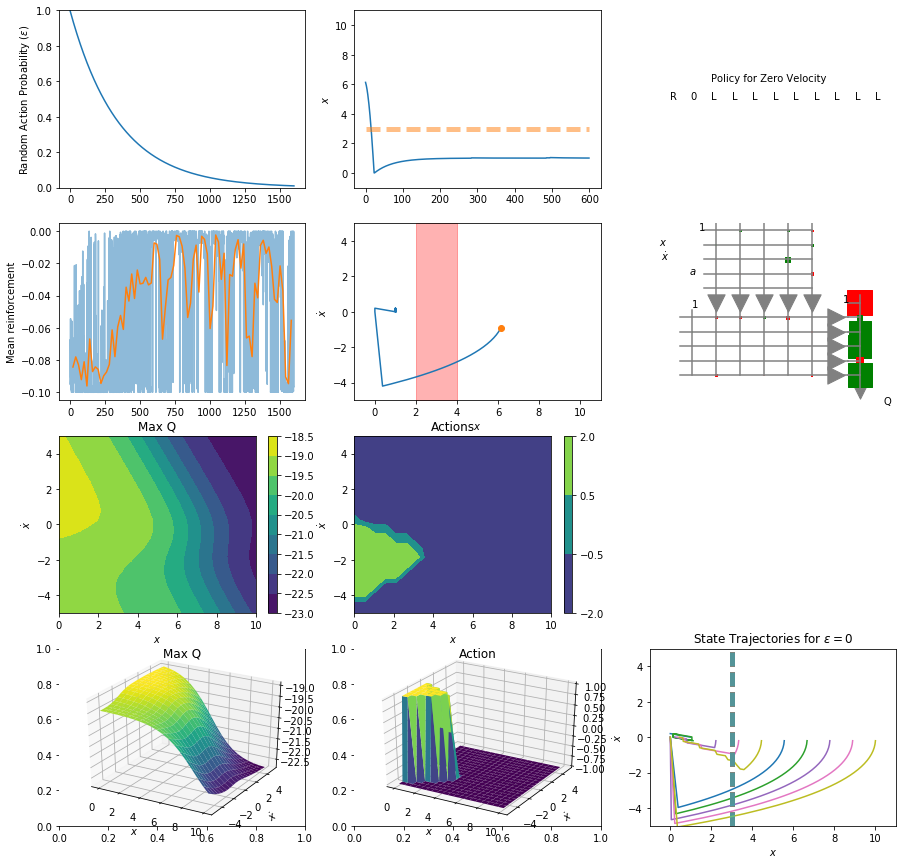

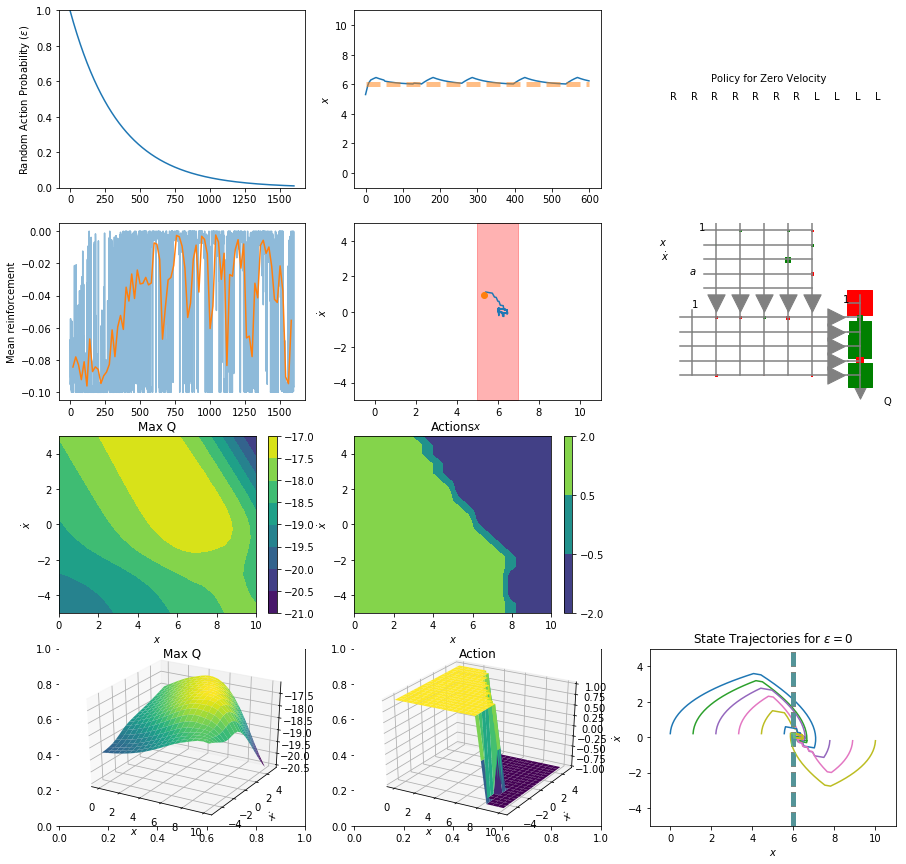

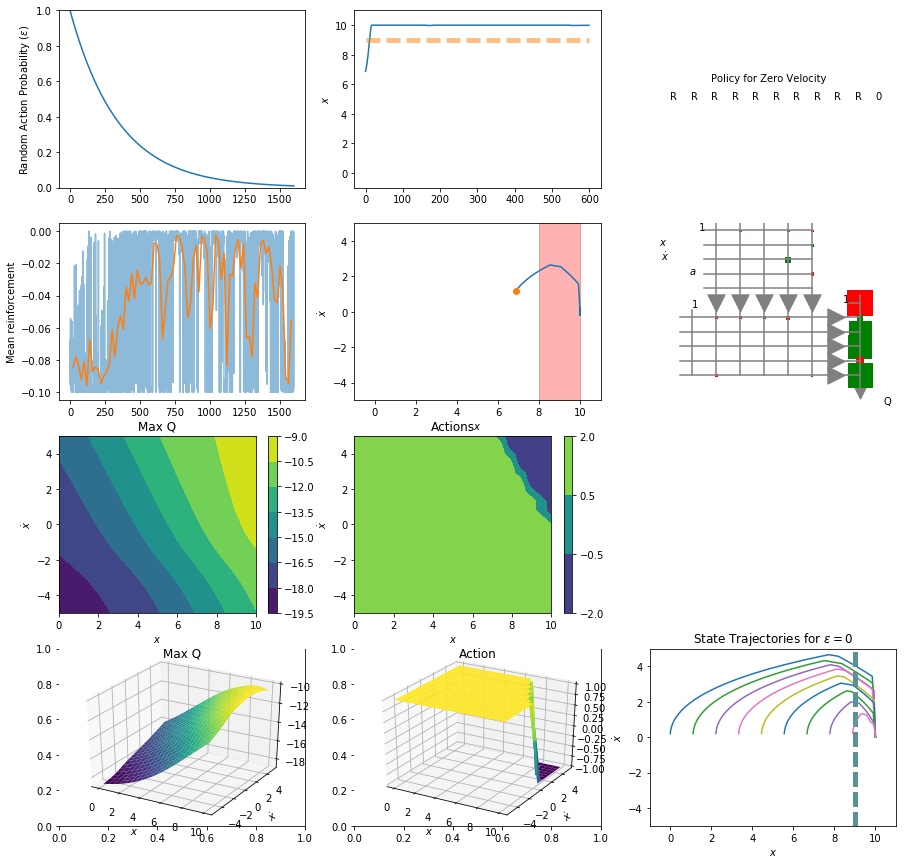

In [12]:
for goal in range(0,10,3):
    samples = makeSamples(qnet, nStepsPerTrial, goal, True)
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]    
    
    fig = plt.figure(figsize=(15,15))
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
    testIt(qnet,10,500,goal)
    display(fig);
clear_output(wait=True)

This was one of the most inconsistent ones. Increasing the number of steps per trial sometimes did better, sometimes worse, than base. Its worse side far outweighed the best side of it, so I'll see how dropping this number does instead.

### Fourth Test

Try dropping `nStepsPerTrial` down to 400.

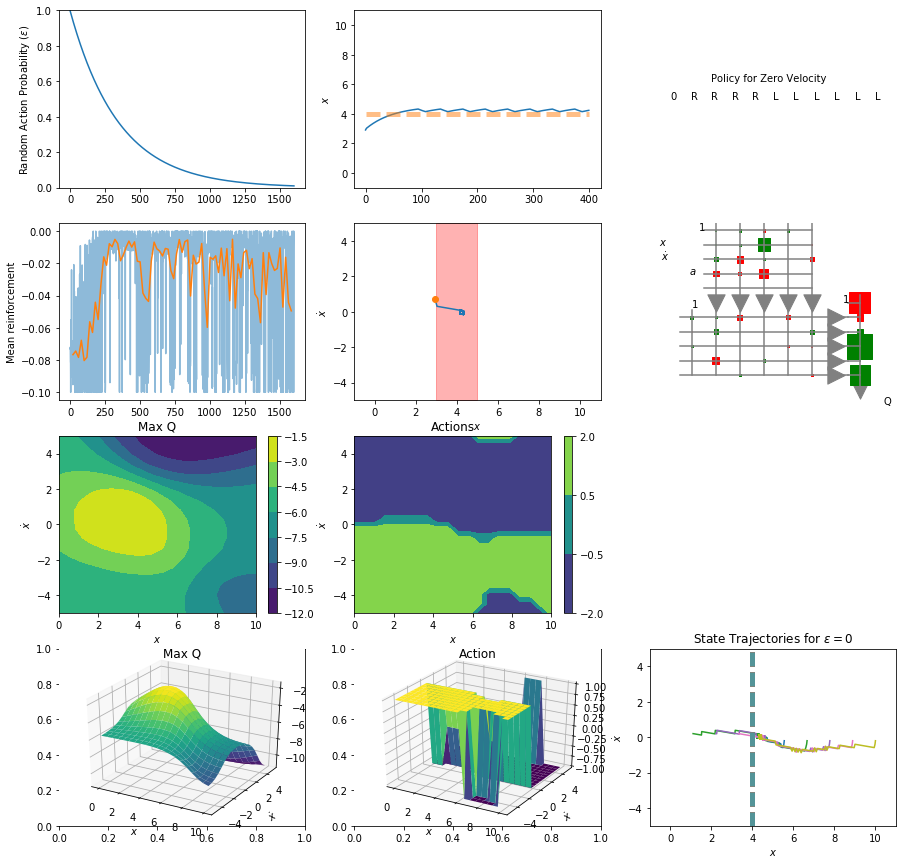

In [13]:
gamma = 0.999
nTrials = 1600
nStepsPerTrial = 400 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0,10), (-1,1)))

fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
prevGoal = -1

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)
    #print("samples: {}, goal: {}".format(samples[0],samples[0][2]))
    goal = samples[0][2]
    if goal != prevGoal:
        #print(goal)
        prevGoal = goal

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        testIt(qnet,10,500,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

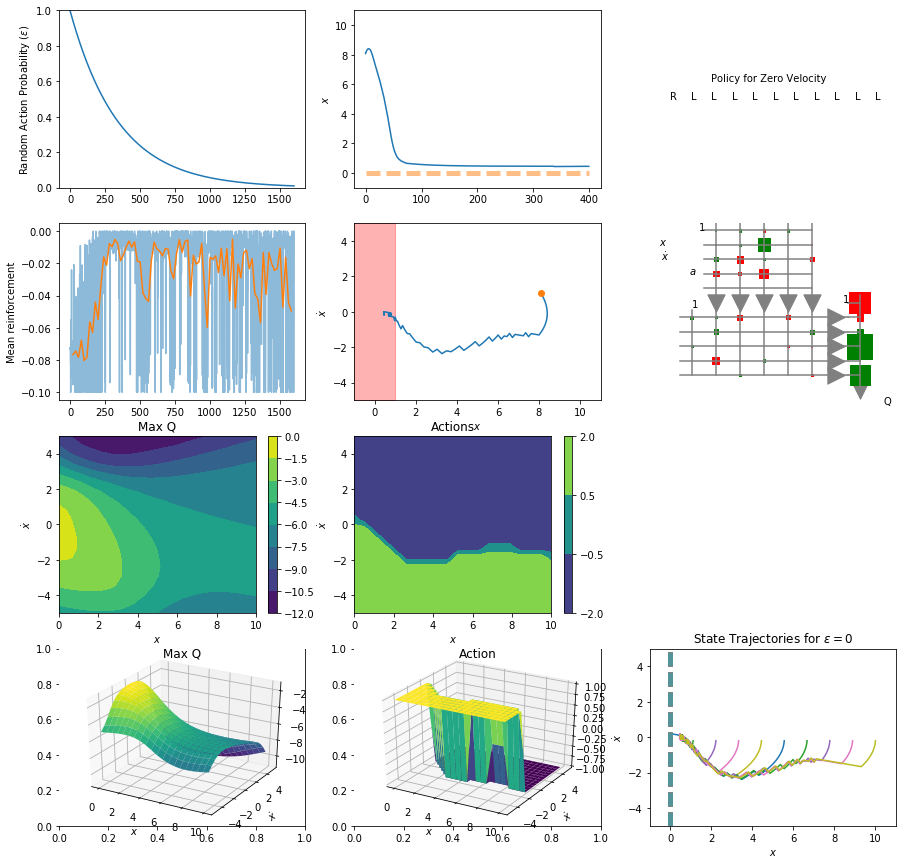

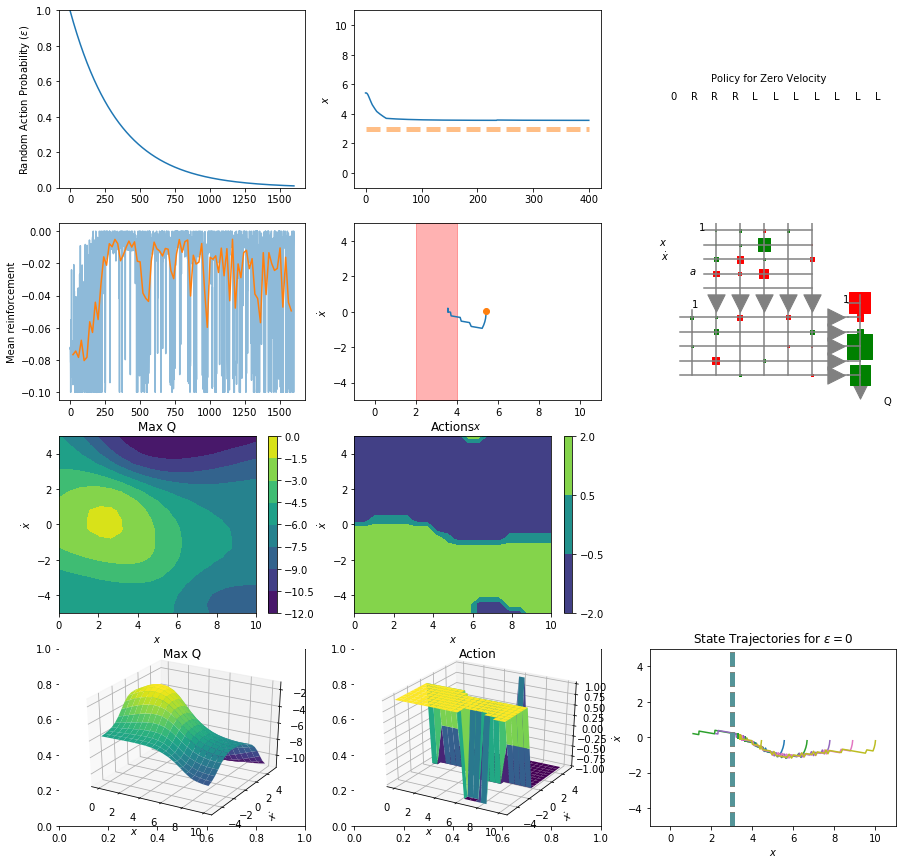

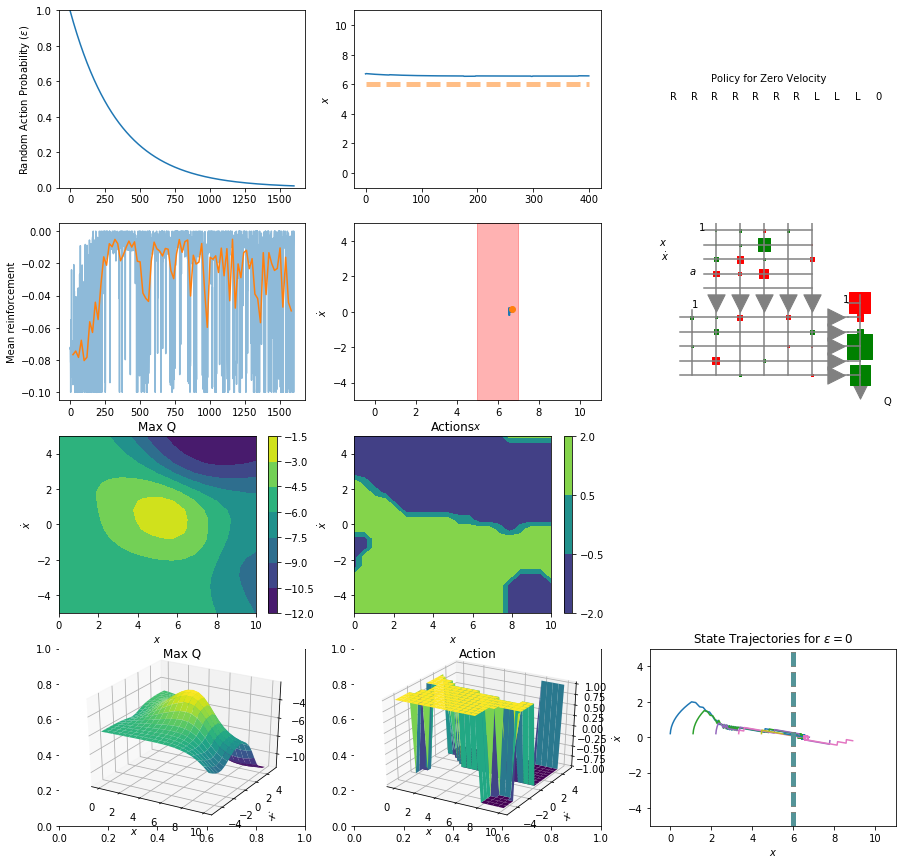

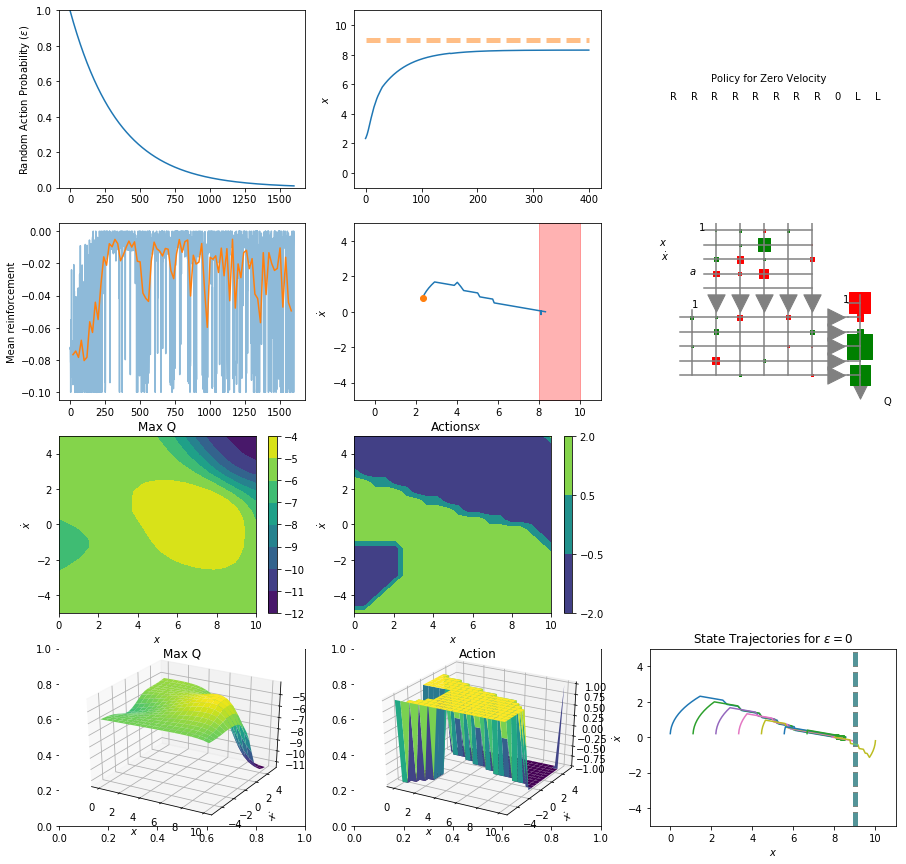

In [14]:
for goal in range(0,10,3):
    samples = makeSamples(qnet, nStepsPerTrial, goal, True)
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]    
    
    fig = plt.figure(figsize=(15,15))
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
    testIt(qnet,10,500,goal)
    display(fig);
clear_output(wait=True)

Interestingly enough, this ended up producing the best results most consistently. Maybe having a higher number of steps per iteration (beyond 400) overtrains and ends up losing some of the relevant information.

### Fifth Test

Now I'll adjust hidden layers/units. The idea here is to double the weights in the second layer in order to try and capture twice as much information for each input. From there, I'd like to project that information down slowly to 1 output in the hopes that it transfers well.

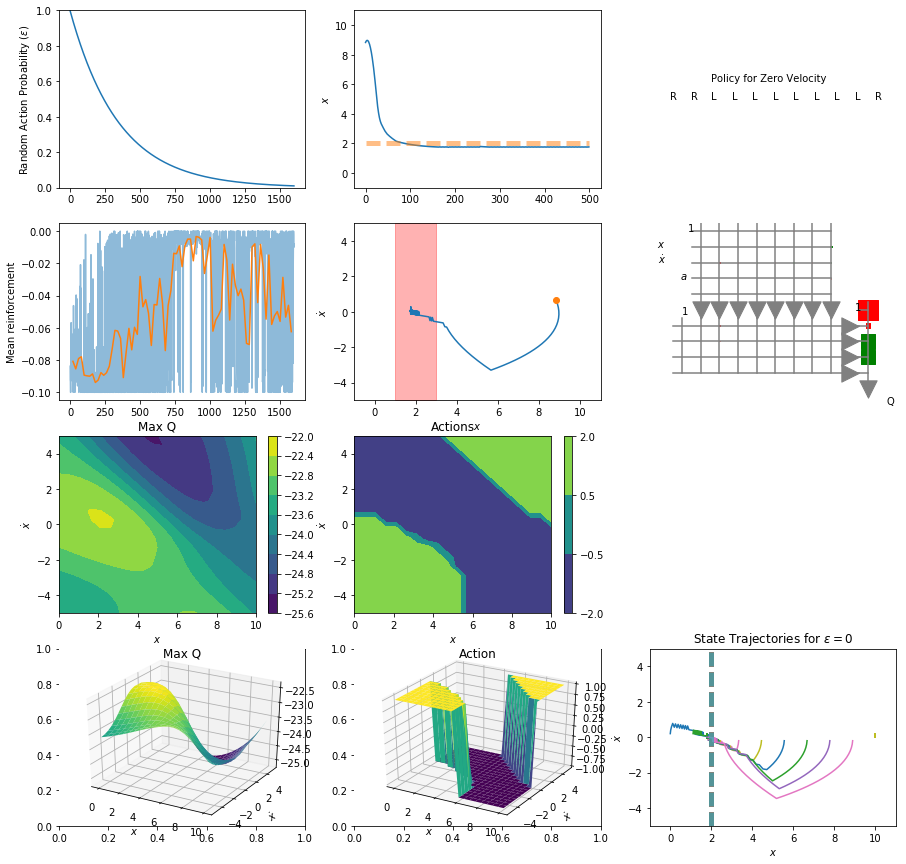

In [15]:
gamma = 0.999
nTrials = 1600
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [8,4]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 8, 4, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0,10), (-1,1)))

fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
prevGoal = -1

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)
    #print("samples: {}, goal: {}".format(samples[0],samples[0][2]))
    goal = samples[0][2]
    if goal != prevGoal:
        #print(goal)
        prevGoal = goal

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        testIt(qnet,10,500,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

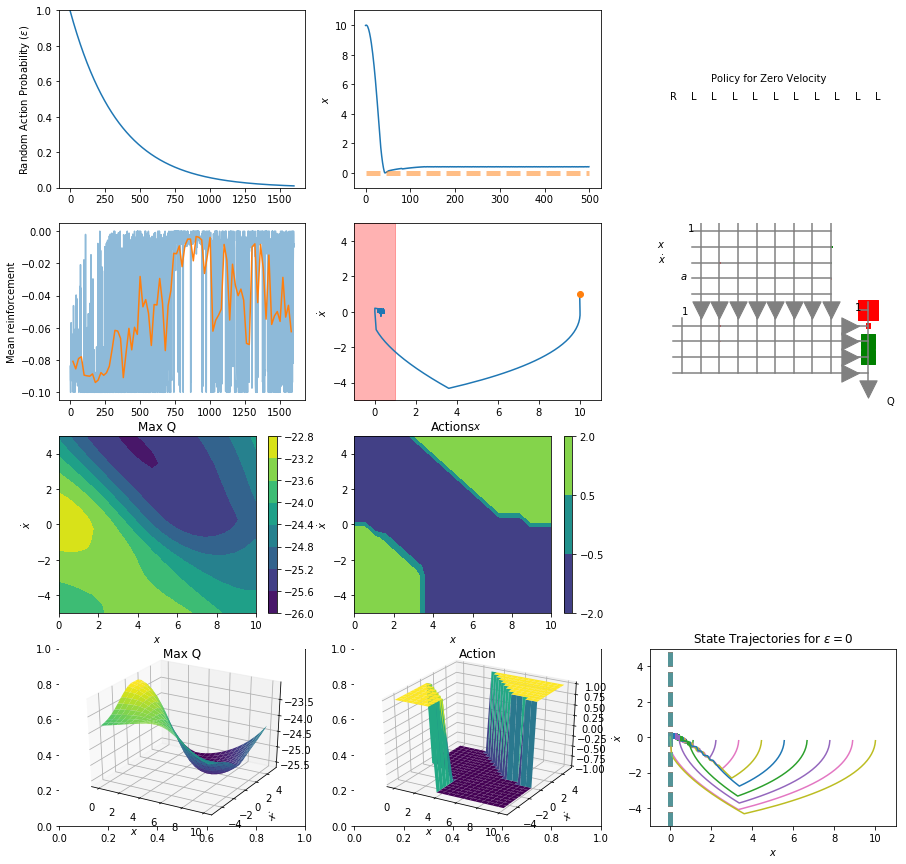

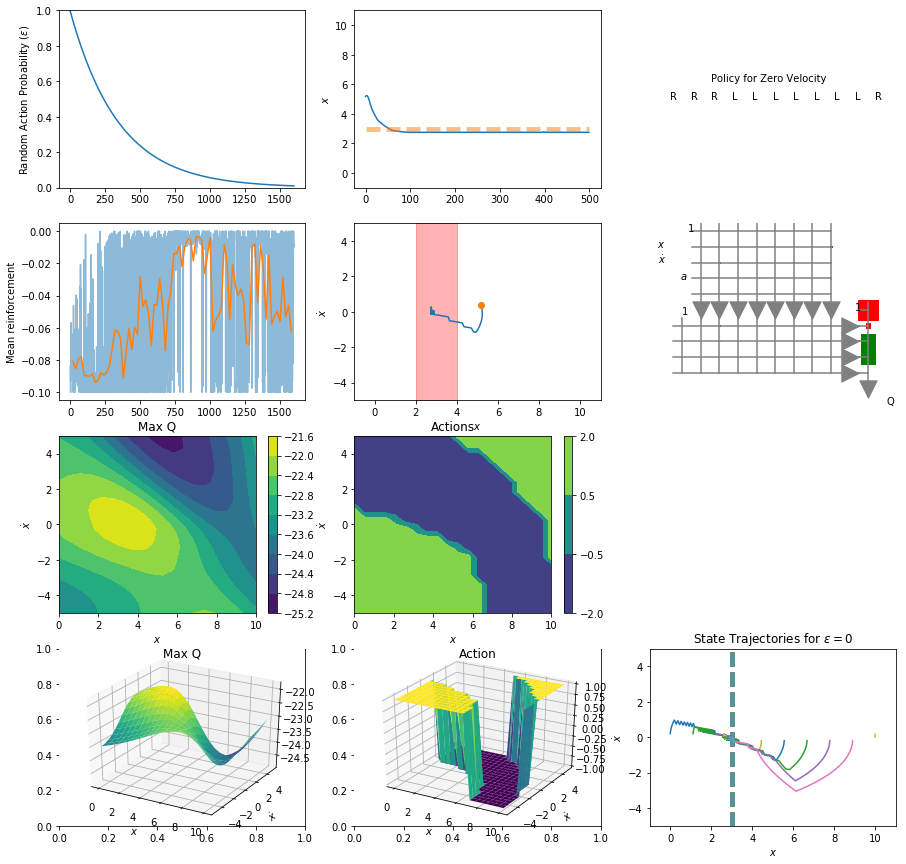

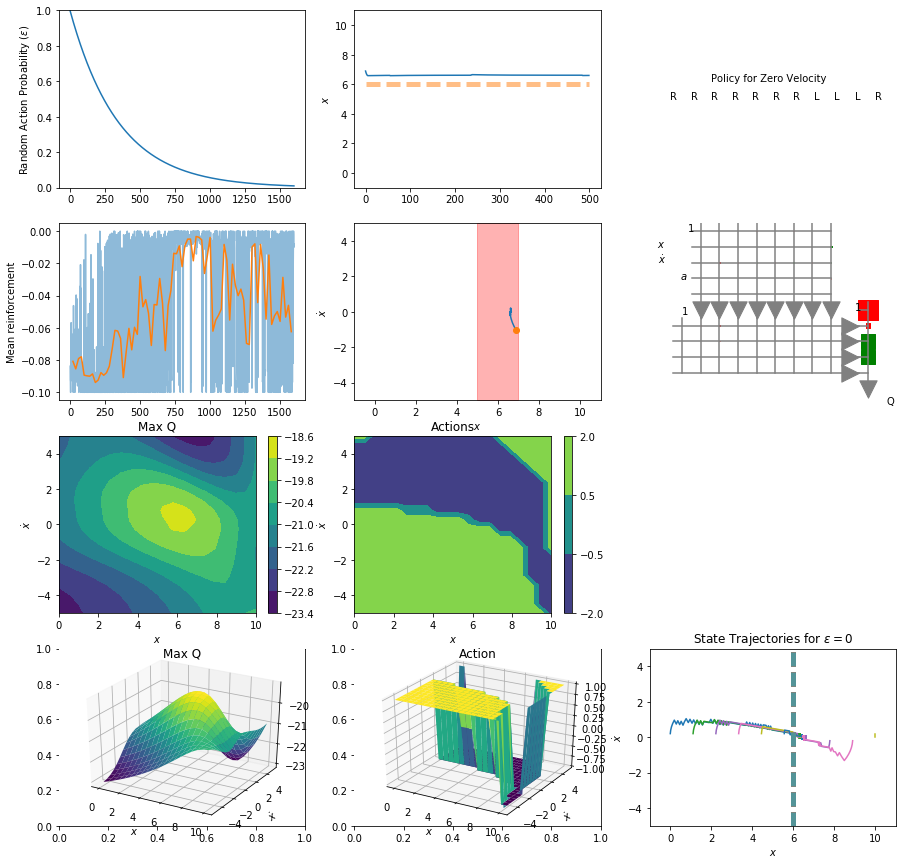

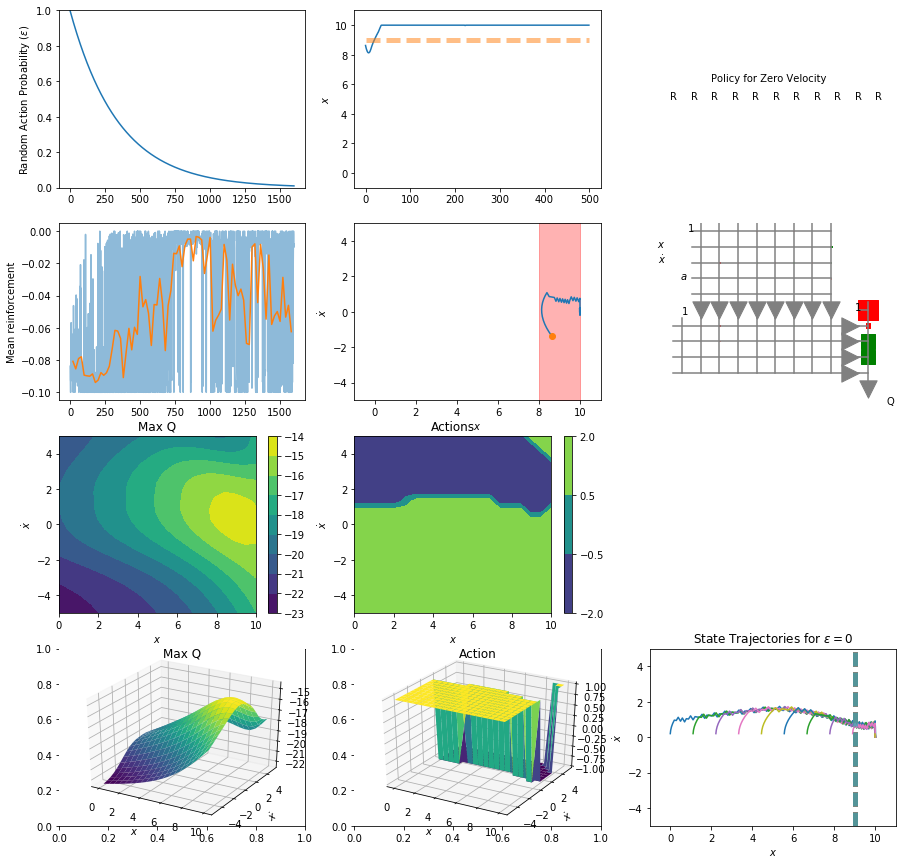

In [16]:
for goal in range(0,10,3):
    samples = makeSamples(qnet, nStepsPerTrial, goal, True)
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]    
    
    fig = plt.figure(figsize=(15,15))
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
    testIt(qnet,10,500,goal)
    display(fig);
clear_output(wait=True)

This adjustment also did really well overall.

### Accumulation of what appears to be best

Decreasing `nStepsPerTrial` to 400. Increasing `nSCGIterations` to 40. Adjusting the 2 middle hidden layers from [5,5] to [8,4]. Since those 3 things individually increased accuracy of the algorithm, I'd like to combine them all into one. I expect this will be the best set of parameters.

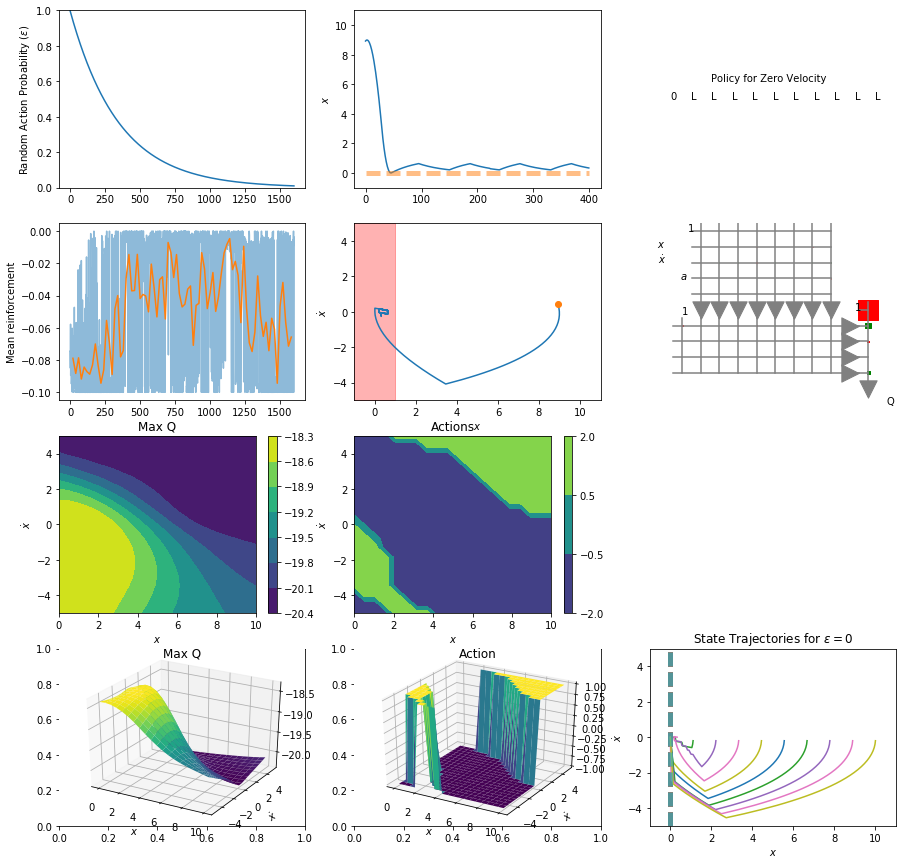

In [17]:
gamma = 0.999
nTrials = 1600
nStepsPerTrial = 400 
nSCGIterations = 40
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [8,4]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 8, 4, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0,10), (-1,1)))

fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
prevGoal = -1

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)
    #print("samples: {}, goal: {}".format(samples[0],samples[0][2]))
    goal = samples[0][2]
    if goal != prevGoal:
        #print(goal)
        prevGoal = goal

    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        testIt(qnet,10,500,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

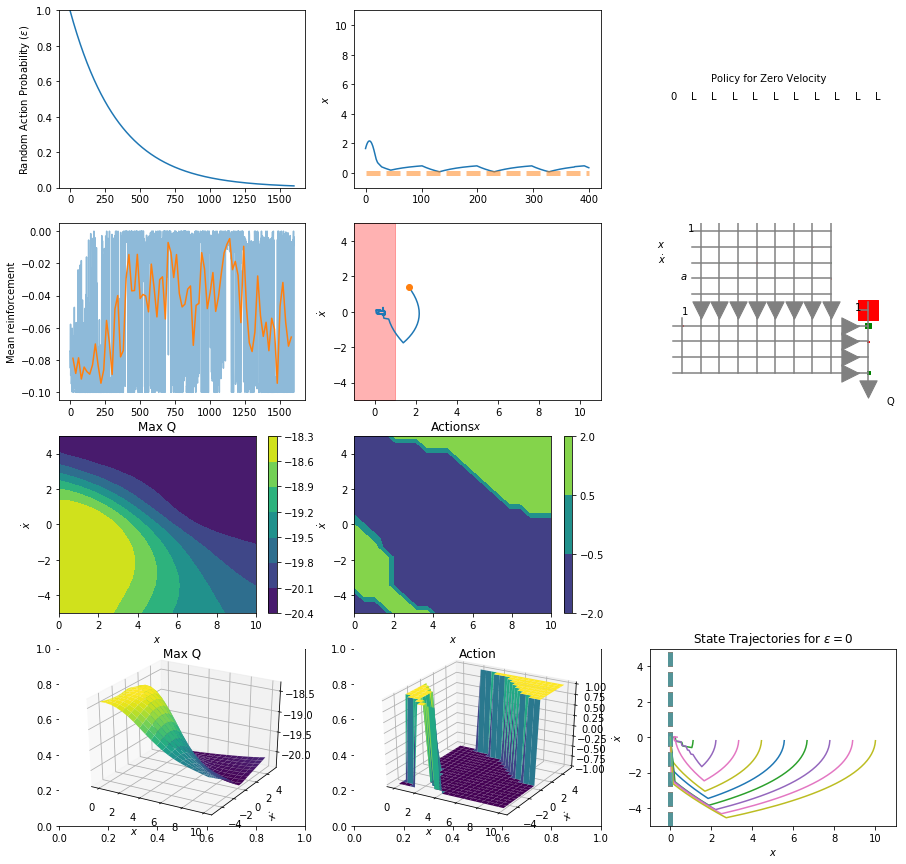

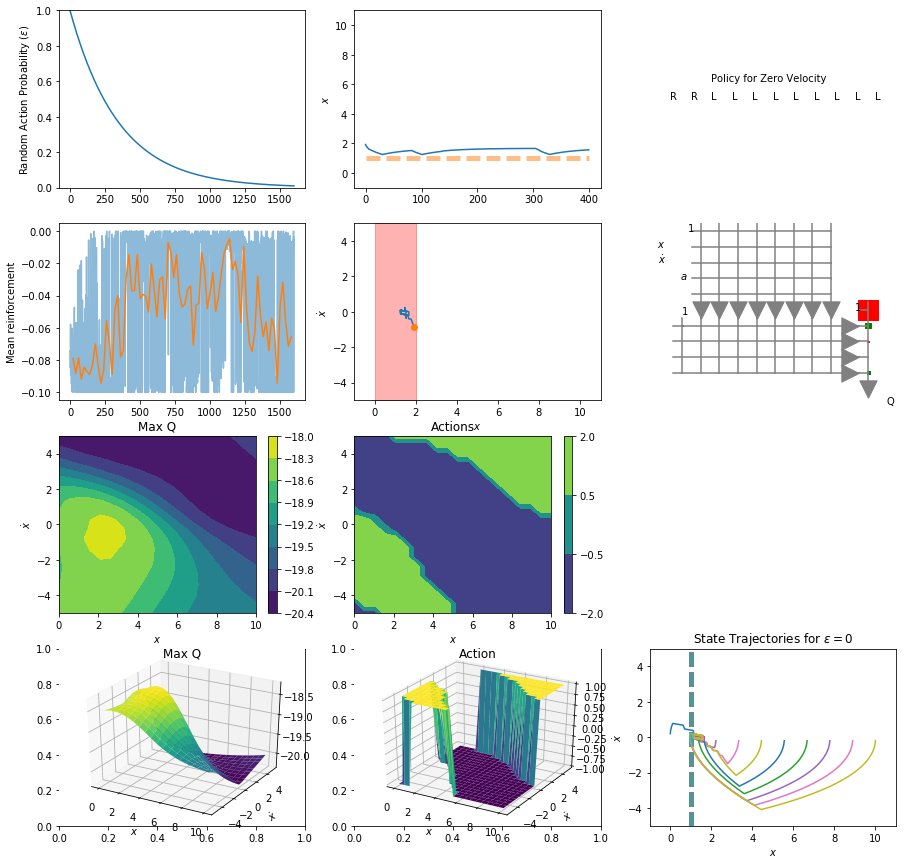

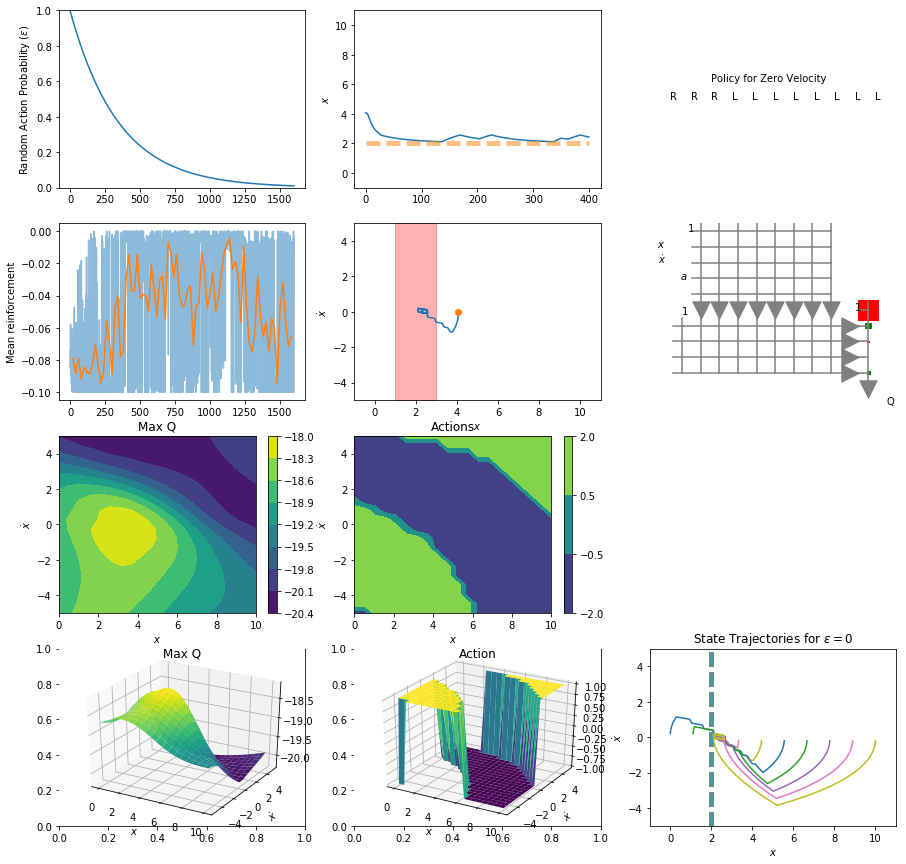

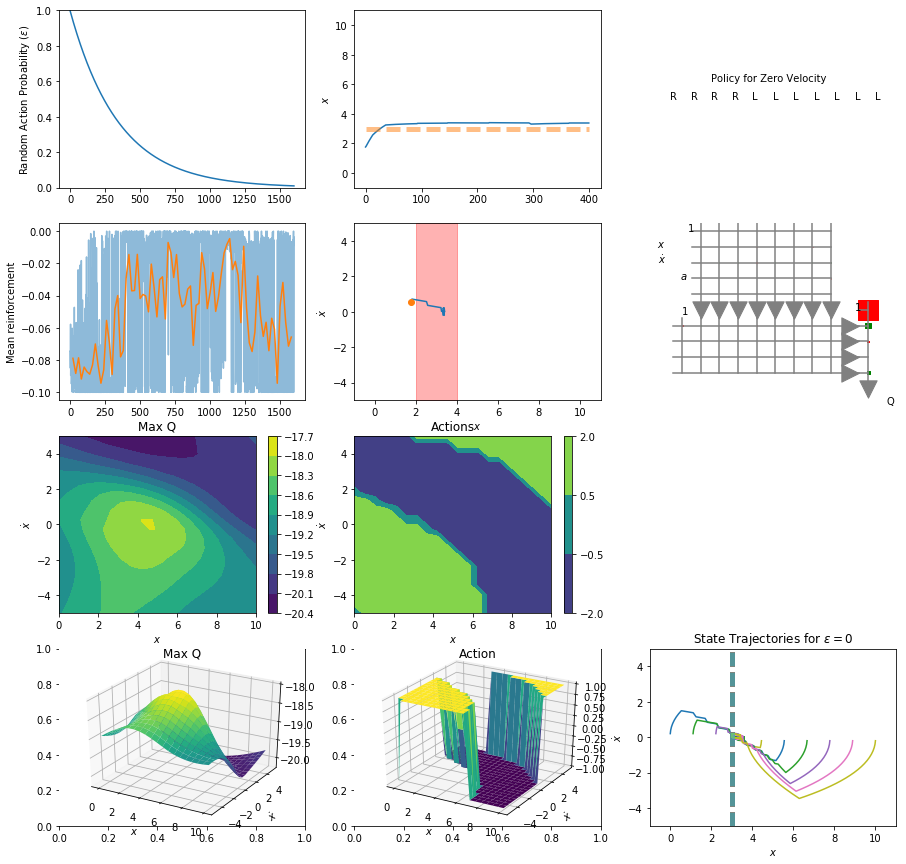

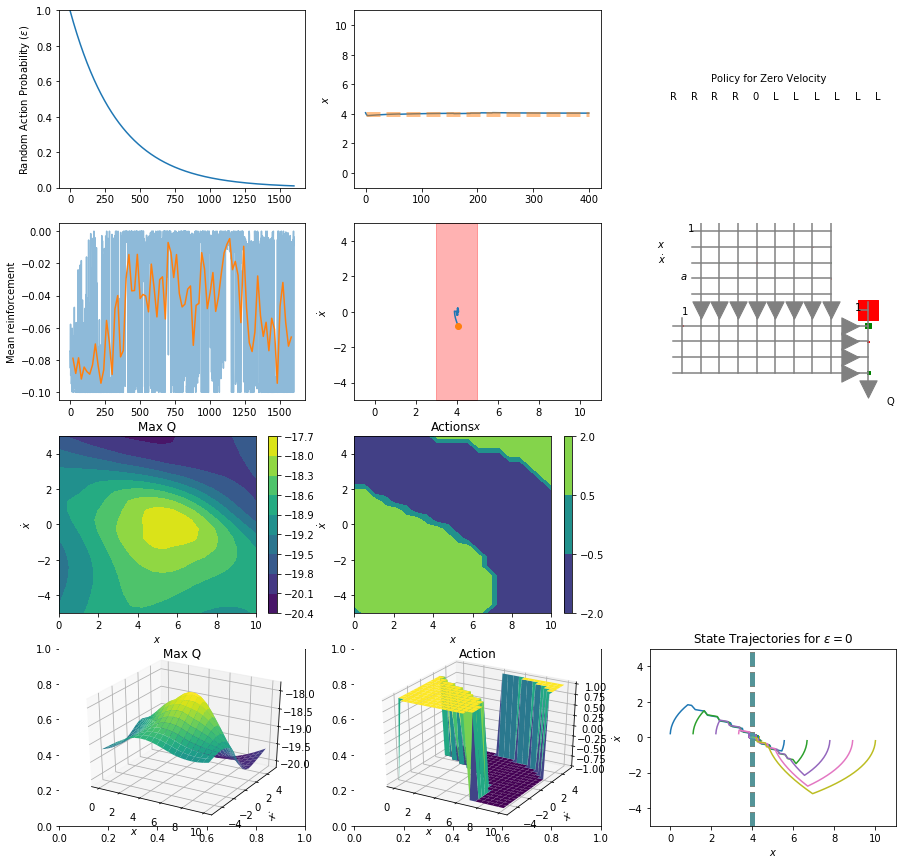

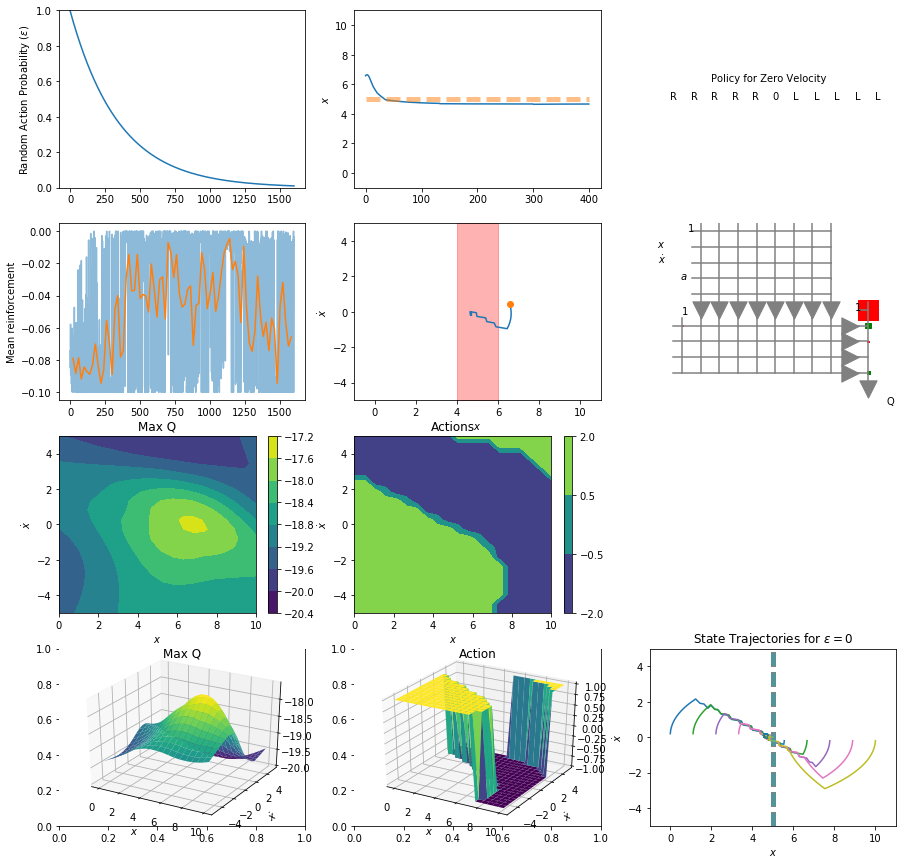

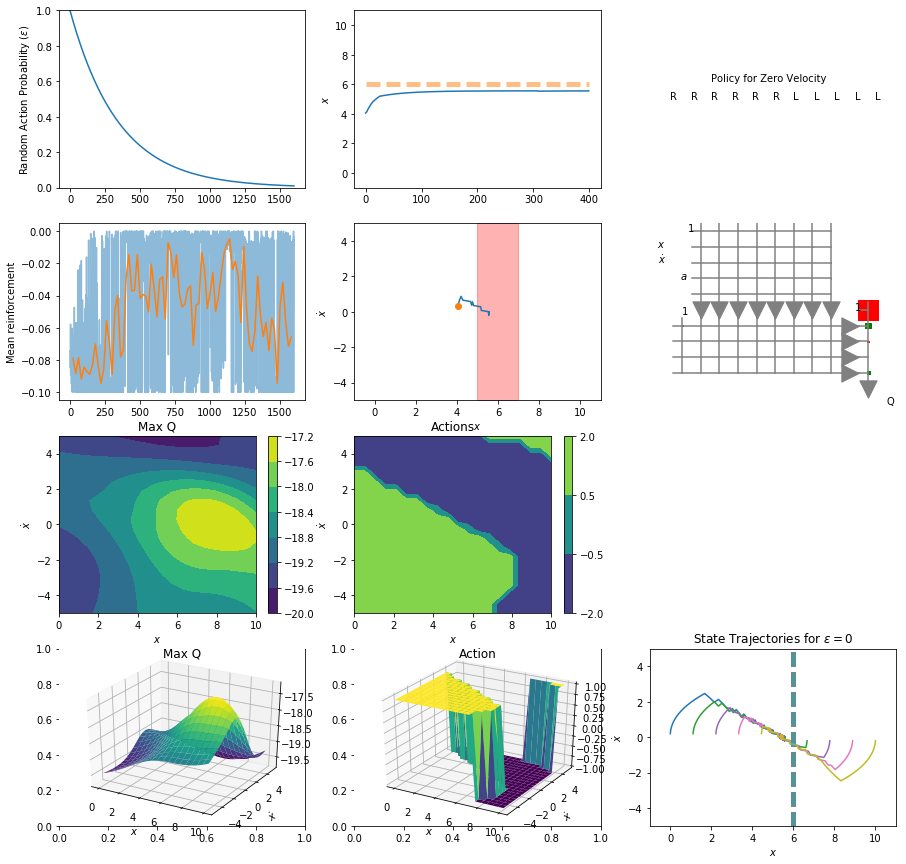

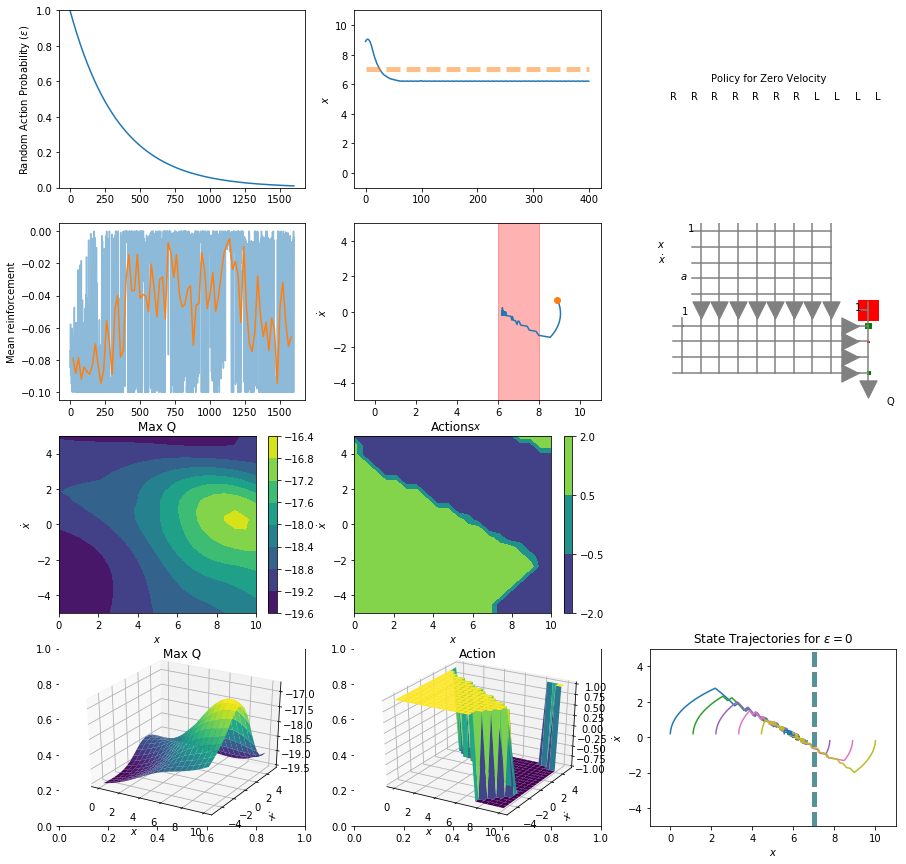

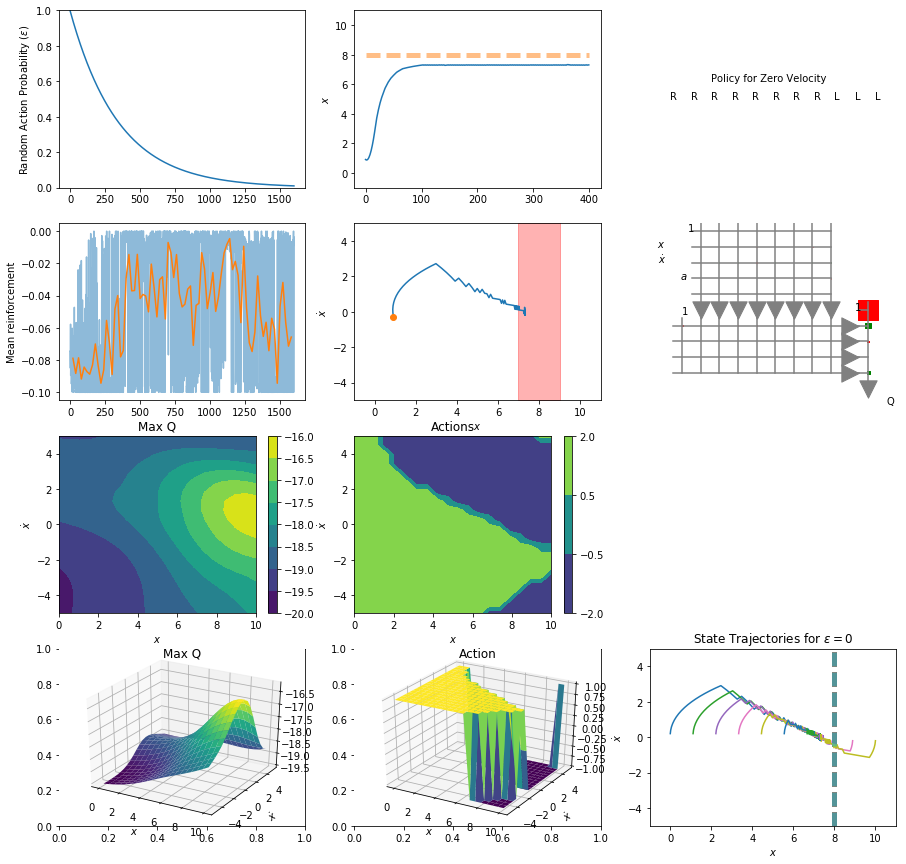

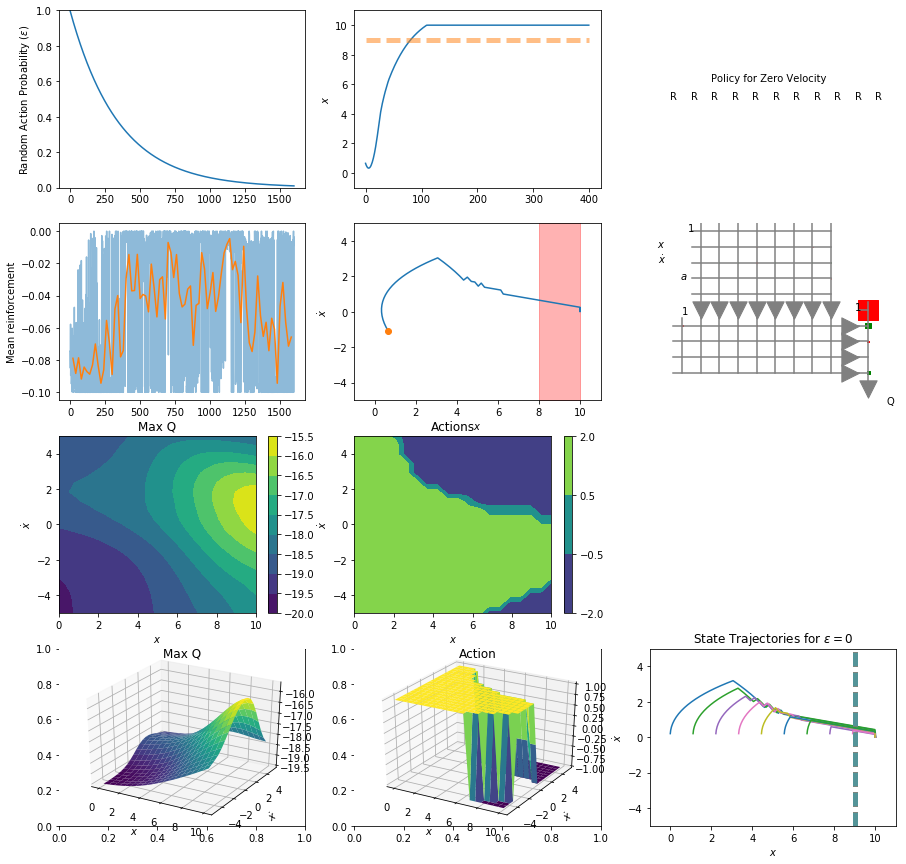

In [18]:
for goal in range(10):
    samples = makeSamples(qnet, nStepsPerTrial, goal, True)
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]    
    
    fig = plt.figure(figsize=(15,15))
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
    testIt(qnet,10,500,goal)
    display(fig);
clear_output(wait=True)

After running this multiple times as well, it performed excellently every trial I ran. At its worst, it would run about 1 unit away from a couple of the possible goals. Occasionally there would be one or two trajectories that were inaccurate for a couple of different goals too. This phenomena actually happened here and there with every different setup I ran. Since position and goal are randomly generated for each sample, there is a reasonable chance that some states were never seen very much. This means that the algorithm did not have enough data in some states to accurately predict their trajectories to the goal.

I also found it interesting how sometimes the policy would be perfect, but sometimes miss it by one left or right. By perfect, I mean it would go left and right correctly to get to the goal and learn to stay still once it hits the goal. When it was close, it would get to the goal and either want to continue left, or continue right, instead of staying still. This may happen because of the velocity of the marble. For instance, maybe the marble is coming from the right of the goal really quickly. When it hits the goal, the best way for the marble to stay in the range of the goal is by getting pushed to the right, instead of staying still.